In [2]:
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import scipy
import math
import os
import sys

print(f'python version: {sys.version}')
print(f'numpy version: {np.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'nibabel version: {nib.__version__}')

NEAR_ZERO_THRESHOLD = 1e-6


def int2seg(intensity):
    if intensity <= 7:
        return f"C{intensity}"
    elif intensity > 7 and intensity <= 19:
        return f"T{intensity - 7}"
    else:
        return f"L{intensity - 19}"


df = pd.read_csv("mendez_df.csv")  #Mendez values
df.head()

python version: 3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:49:06) 
[Clang 14.0.6 ]
numpy version: 1.23.5
pandas version: 1.5.3
nibabel version: 5.1.0


,Segment,MEAN,STD,Mesure
0,C2,11.3,1.5,DREZ length
1,C2,12.6,0.9,Seg.L at dorsal CE
2,C2,13.1,1.0,Seg.L at BE
3,C2,24.4,0.8,Inf.Art facet to CR distance
4,C2,15.5,4.2,IF to RR distance


In [3]:
sct_dir = '../../spinalcordtoolbox/data/PAM50/template/'
print(sct_dir)

../../spinalcordtoolbox/data/PAM50/template/


In [28]:
# Import foramen data
#foramen_level = nib.load('PAM50_intervertebral_foramen_sandrine.nii.gz') # TODO add path
foramen_level = nib.load('test_foramen.nii.gz')

x_f, y_f, z_f = np.where(foramen_level.get_fdata() > NEAR_ZERO_THRESHOLD)
new_order = np.argsort(z_f)[::-1]
x_f = [x_f[i] for i in new_order]
y_f = [y_f[i] for i in new_order]
z_f = [z_f[i] for i in new_order]

In [67]:
# Import Centerline data
center = nib.load(os.path.join(sct_dir, 'PAM50_centerline.nii.gz'))
x_c, y_c, z_c = np.where(center.get_fdata() > NEAR_ZERO_THRESHOLD)
new_order = np.argsort(z_c)[::-1]
x_c = [x_c[i] for i in new_order]
y_c = [y_c[i] for i in new_order]
z_c = [z_c[i] for i in new_order]

# Import Cord data
PATH = os.path.join(sct_dir, 'PAM50_cord.nii.gz')
cord = nib.load(PATH)
p50_mask = cord.get_fdata()
x_cord, y_cord, z_cord = np.where(p50_mask > 0)
new_order = np.argsort(z_cord)[::-1]
x_cord = [x_cord[i] for i in new_order]
y_cord = [y_cord[i] for i in new_order]
z_cord = [z_cord[i] for i in new_order]

PATH_cerv = 'label_center_roots_cervical.nii.gz'
cerv = nib.load(PATH_cerv)
p50_cerv = cerv.get_fdata()
x_cerv, y_cerv, z_cerv = np.where(p50_cerv > 0)
new_order = np.argsort(z_cerv)[::-1]
x_cerv = [x_cerv[i] for i in new_order]
y_cerv = [y_cerv[i] for i in new_order]
z_cerv = [z_cerv[i] for i in new_order]

PATH_cr = 'label_caudal_rostral_roots.nii.gz'
cr = nib.load(PATH_cr)
p50_cr = cr.get_fdata()
x_cr, y_cr, z_cr = np.where(p50_cr > 0)
new_order = np.argsort(z_cr)[::-1]
print(z_cerv)
x_cr = [x_cr[i] for i in new_order]
y_cr = [y_cr[i] for i in new_order]
z_cr = [z_cr[i] for i in new_order]

x_ca = [x_cr[i] for i in range(8) if i % 2 == 1]
y_ca = [y_cr[i] for i in range(8) if i % 2 == 1]
z_ca = [z_cr[i] for i in range(8) if i % 2 == 1]

x_ro = [x_cr[i] for i in range(8) if i % 2 == 0]
y_ro = [y_cr[i] for i in range(8) if i % 2 == 0]
z_ro = [z_cr[i] for i in range(8) if i % 2 == 0]

print(z_ca, z_ro)


[960, 932, 891, 862, 830, 796, 771, 732]
[945, 905, 875, 852] [969, 943, 901, 872]


## Estimate without STD
Take smallest distance bewtenn SC centerline (shifted by average diameter at dorsal rootlet entry and intervertebral foramen) (Sandrine)


In [80]:
len_level = {}
z_ref = np.array(range(min(z_c), max(z_c) + 1))
z_c = z_ref
dist_list = {"ref_center": [], "ref_caudal": [], "ref_rostral": [], "caudal": [], "rostral": [], "ratio_rostral": [],
             "ratio_caudal": [], "without z": []}
level_list = []
RATIO =1.5
for i in range(len(x_f)):
    # Get coordinates of intervertebral foramen
    x = x_f[i]
    y = y_f[i]
    z = z_f[i]

    # Get level
    level = int(foramen_level.get_fdata()[x, y, z])
    print('Level', level)
    print(f"IF \t x:{x} \t y:{y} \t z:{z}")
    # Get correspondance of level number (2 --> C2, etc.)
    seg = int2seg(level)
    # Get mendez measures for the corresponding level
    seg_df = df[df.Segment == seg]
    RR = seg_df[seg_df.Mesure == "IF to RR distance"]
    CR = seg_df[seg_df.Mesure == "IF to CR distance"]
    W = seg_df.loc[seg_df.Mesure == "Dorsal width"].iloc[0]
    w_mean = W.MEAN  # get mean value of dorsal width
    rr_mean = RR.MEAN.to_list()[0]  # Get mean distance from rostral rootlet to interverteral foramen
    cr_mean = CR.MEAN.to_list()[0]  # Get mean distance from caudal rootlet to interverteral foramen
    print(f"Seg: {seg} \t Rostral mean (mm): {rr_mean} \t Caudal mean(mm): {cr_mean} \t Width(mm): {w_mean}")
    w_mean = w_mean * 2
    rr_mean = rr_mean * 2 * RATIO
    cr_mean = cr_mean * 2 * RATIO
    print(f"Seg: {seg} \t Rostral mean (vx): {rr_mean} \t Caudal mean(vx): {cr_mean} \t Width(vx): {w_mean}")

    # Compute the 3D euclidean distance between intervertebral foramen and the back of the SC at dorsal width/2 lateral offset ( in mm)
    new_x = (x_c - w_mean * 0.5)[0]  # x value centerline - dorsal width /2 offset
    new_y = min(
        np.where(cord.get_fdata()[int(new_x), :, z] > 0)[0])  # y value of the SC border at x = new_x and z = foramen
    print(f"new x: {new_x}, new y: {new_y}")
    distance_foramen_ctl = np.sqrt((x_c - w_mean - x) ** 2 + (new_y - y) ** 2 + (
            z_c - z) ** 2)
    # Get the closest distance to the rostral rootlet compared to the Mendez value
    rostral_diff = np.array([np.abs(i - rr_mean) for i in distance_foramen_ctl])
    # Only use slices higher than the foramen
    rostral = np.argmin(rostral_diff[-len(z_ref[z_c > z]) - 1::])
    z_ref_r = z_c[-len(z_c[z_c > z]) - 1::]
    # Get the slice number (adjusted since the centerline starts at slice 55 not 0)
    r_z = z_ref_r[rostral]

    # Get the closest distance to the caudal rootlet compared to the Mendez value
    caudal_diff = np.array([np.abs(i - cr_mean) for i in distance_foramen_ctl])
    # Only use slices higher than the foramen
    caudal = np.argmin(caudal_diff[-len(z_ref[z_c > z]) - 1::])
    # Get the slice number (adjusted since the centerline starts at slice 55 not 0)
    c_z = z_ref_r[caudal]

    print(f"Rostral, closest dist: {rostral}, rostral slice: {r_z}")
    dist_list["rostral"].append(rr_mean)
    dist_list["caudal"].append(cr_mean)
    level_list.append(level)
    print(f"Caudal, closest dist: {caudal}, Caudal slice: {c_z}")
    center_dist = np.sqrt((x_cerv[i] - x) ** 2 + (y_cerv[i] - y) ** 2 + (
            z_cerv[i] - z) ** 2)
    #print(ref_dist)
    dist_list["ref_center"].append(center_dist)  # foramen to midle DREZ
    try:
        caudal_dist = np.sqrt((x_ca[i] - x) ** 2 + (y_ca[i] - y) ** 2 + (
                z_ca[i] - z) ** 2)
        dist_list["ref_caudal"].append(caudal_dist)  # foramen to midle DREZ
        rostral_dist = np.sqrt((x_ro[i] - x) ** 2 + (y_ro[i] - y) ** 2 + (
                z_ro[i] - z) ** 2)
        dist_list["ref_rostral"].append(rostral_dist)  # foramen to midle DREZ
        dist_list["ratio_caudal"].append(caudal_dist / cr_mean)  # Ratio
        dist_list["ratio_rostral"].append(rostral_dist / cr_mean)  # Ratio
    except:
        dist_list["ref_caudal"].append(np.NAN)  # foramen to midle DREZ
        dist_list["ref_rostral"].append(np.NAN)  # foramen to midle DREZ
        dist_list["ratio_caudal"].append(np.NAN)  # Ratio
        dist_list["ratio_rostral"].append(np.NAN)  # Ratio
    no_z = np.sqrt((x_cerv[i] - x) ** 2 + (y_cerv[i] - y) ** 2)
    dist_list["without z"].append(no_z)  # distance without z
    # Set slices
    len_level[level] = (r_z, c_z)

Level 2
IF 	 x:37 	 y:72 	 z:932
Seg: C2 	 Rostral mean (mm): 15.5 	 Caudal mean(mm): 10.6 	 Width(mm): 7.88
Seg: C2 	 Rostral mean (vx): 46.5 	 Caudal mean(vx): 31.799999999999997 	 Width(vx): 15.76
new x: 62.12, new y: 66
Rostral, closest dist: 43, rostral slice: 975
Caudal, closest dist: 26, Caudal slice: 958
Level 3
IF 	 x:41 	 y:89 	 z:898
Seg: C3 	 Rostral mean (mm): 16.299999999999997 	 Caudal mean(mm): 10.8 	 Width(mm): 7.18
Seg: C3 	 Rostral mean (vx): 48.89999999999999 	 Caudal mean(vx): 32.400000000000006 	 Width(vx): 14.36
new x: 62.82, new y: 66
Rostral, closest dist: 41, rostral slice: 939
Caudal, closest dist: 18, Caudal slice: 916
Level 4
IF 	 x:42 	 y:88 	 z:865
Seg: C4 	 Rostral mean (mm): 18.1 	 Caudal mean(mm): 10.1 	 Width(mm): 7.11
Seg: C4 	 Rostral mean (vx): 54.300000000000004 	 Caudal mean(vx): 30.299999999999997 	 Width(vx): 14.22
new x: 62.89, new y: 66
Rostral, closest dist: 48, rostral slice: 913
Caudal, closest dist: 16, Caudal slice: 881
Level 5
IF 	 x:42

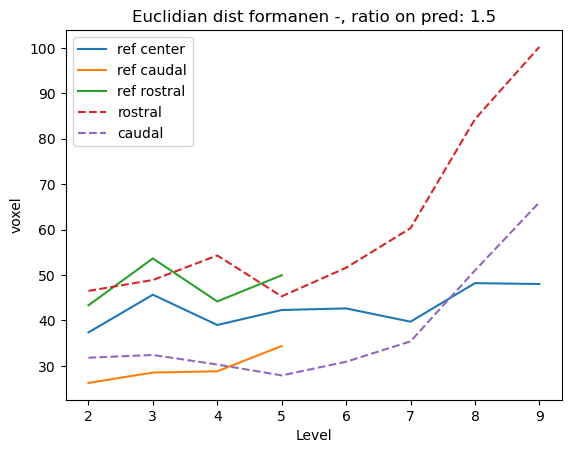

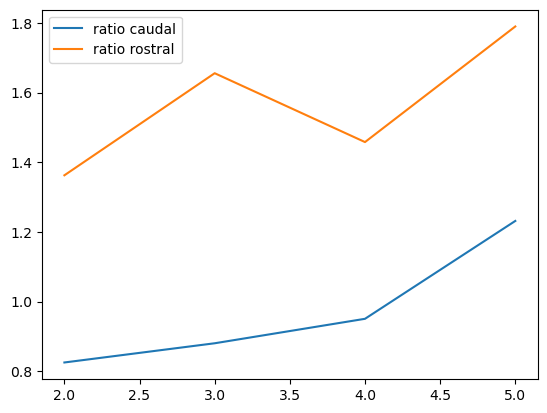

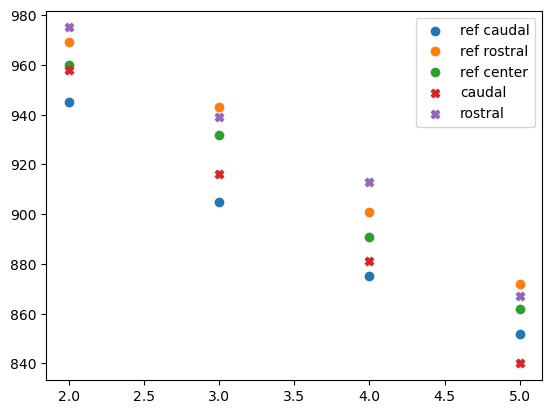

[960, 932, 891, 862, 830, 796, 771, 732]


In [81]:
order = np.argsort(level_list)
#PLOT distances
plt.plot([level_list[i] for i in order], [dist_list["ref_center"][i] for i in order], label="ref center")
plt.plot([level_list[i] for i in order], [dist_list["ref_caudal"][i] for i in order], label="ref caudal")
plt.plot([level_list[i] for i in order], [dist_list["ref_rostral"][i] for i in order], label="ref rostral")
plt.plot([level_list[i] for i in order], [dist_list["rostral"][i] for i in order], label="rostral", linestyle="--")
plt.plot([level_list[i] for i in order], [dist_list["caudal"][i] for i in order], label="caudal", linestyle="--")
#plt.plot([level_list[i] for i in order], [dist_list["without z"][i] for i in order], label="center without Z")
plt.title(f"Euclidian dist formanen -, ratio on pred: {RATIO}")
plt.xlabel("Level")
plt.ylabel("voxel")
plt.legend()
plt.show()

#plot ratio
plt.plot([level_list[i] for i in order], [dist_list["ratio_caudal"][i] for i in order], label="ratio caudal")
plt.plot([level_list[i] for i in order], [dist_list["ratio_rostral"][i] for i in order], label="ratio rostral")
plt.legend()

plt.show()

#plot ratio
plt.scatter([*range(2,len(z_ca)+2)], z_ca, label="ref caudal")
plt.scatter([*range(2,len(z_ro)+2)], z_ro, label="ref rostral")
plt.scatter([*range(2,len(z_ro)+2)], z_cerv[:4], label="ref center")
plt.scatter([*range(2,len(z_ca)+2)], [len_level[i][1] for i in range(2,6)], label="caudal", marker="X")
plt.scatter([*range(2,len(z_ro)+2)], [len_level[i][0] for i in range(2,6)], label="rostral", marker="X")
plt.legend()

plt.show()
print(z_cerv)

In [27]:
cord_mask = np.copy(p50_mask)
for lvl in len_level:
    level_r = int(len_level[lvl][0])
    level_c = int(len_level[lvl][1])
    cord_mask[:, :, level_r][cord_mask[:, :, level_r] > 0] = lvl
    cord_mask[:, :, level_c][cord_mask[:, :, level_c] > 0] = lvl
cord_mask[:, :, :][cord_mask[:, :, :] == 1] = 0
test_img = nib.Nifti1Image(cord_mask, header=cord.header, affine=cord.affine)
nib.save(test_img, f'foramen_label_without_std.nii.gz')  # TO CHANGE path output

## Estimate with STD 
Take smallest distance bewtenn SC centerline (shifted by average diameter at dorsal rootlet entry and intervertebral foramen) (Sandrine)


In [ ]:
z_ref = np.array(range(min(z_c), max(z_c) + 1))
z_c = z_ref
for i in range(len(x_f)):
    # Get coordinates of intervertebral foramen
    x = x_f[i]
    y = y_f[i]
    z = z_f[i]
    # Get level
    level = int(foramen_level.get_fdata()[x, y, z])
    print('Level', level)
    # Get correspondance of level number (2 --> C2, etc.)
    seg = int2seg(level)
    print(seg)
    # Get mendez measures for the corresponding level
    seg_df = df[df.Segment == seg]
    RR = seg_df[seg_df.Mesure == "IF to RR distance"]
    CR = seg_df[seg_df.Mesure == "IF to CR distance"]
    W = seg_df.loc[seg_df.Mesure == "Dorsal width"].iloc[0]
    w_mean = W.MEAN  # get mean value of dorsal width
    rr_mean = RR.MEAN.to_list()[0]  # Get mean distance from rostral rootlet to interverteral foramen
    cr_mean = CR.MEAN.to_list()[0]  # Get mean distance from caudal rootlet to interverteral foramen
    rr_std = RR.STD.to_list()[0]  # Get std for mean distance from rostral rootlet to interverteral foramen
    cr_std = CR.STD.to_list()[0]  # Get std for mean distance from caudal rootlet to interverteral foramen
    # Get distance for +/- 95% probability
    min_rr = rr_mean - 2 * rr_std
    max_rr = rr_mean + 2 * rr_std
    min_cr = cr_mean - 2 * cr_std
    max_cr = cr_mean + 2 * cr_std
    print("Rostral dist", max_rr, rr_mean, min_rr)
    print("Caudal dist", max_cr, cr_mean, min_cr)
    # Compute the 3D euclidean distance between intervertebral foramen and the back of the SC at dorsal width/2 lateral offset ( in mm)
    new_x = (x_c - w_mean)[0]  # x value centerline - dorsal width /2 offset
    new_z = min(
        np.where(cord.get_fdata()[int(new_x), :, z] > 0)[0])  # y value of the SC border at x = new_x and z = foramen
    distance_foramen_ctl = np.sqrt((x_c - w_mean - x) ** 2 + (new_z - y) ** 2 + (
            z_c - z) ** 2) * 0.5  # 0.5 --> pix dim of PAM50 TODO: remove hardcode
    # min std : most caudal point of the probabilistic distribution 
    # max std : most rostral point of the probabilistic distribution 
    # List with estimation of z value for rostral and caudal (min std, max std, mean)
    all_level = []
    for distance in [max_rr, min_rr, rr_mean, max_cr, min_cr, cr_mean]:
        # Get the closest distance to the rostral rootlet compared to the Mendez value
        rostral_diff = np.array([np.abs(i - distance) for i in distance_foramen_ctl])
        # Only use slices higher than the foramen
        estimate = np.argmin(rostral_diff[-len(z_c[z_c > z]) - 1::])
        z_ref_i = z_ref[-len(z_c[z_c > z]) - 1::]
        # Get the slice number (adjusted since the centerline starts at slice 55 not 0)
        value = z_ref_i[estimate]
        all_level.append(int(value))

    print('Rostral', rr_mean, distance_foramen_ctl[-len(z_c[z_c > z]) - 1::][rostral], all_level[2], z)
    print('Caudal', cr_mean, distance_foramen_ctl[-len(z_c[z_c > z]) - 1::][caudal], all_level[5], z)
    # Set colored label from 0 (the least probable) to 20 (mean value)
    cord_mask = np.copy(p50_mask)
    # Max to mean rostral
    for rng in range(all_level[2], all_level[0]):
        if abs(all_level[0] - all_level[2]) != 0:
            proba = 19 * abs(rng - all_level[2]) / (abs(all_level[0] - all_level[2])) + 1
            cord_mask[:, :, rng][cord_mask[:, :, rng] > 0] = 20 - proba
    # Mean to min rostral 
    for rng in range(all_level[1], all_level[2]):
        if abs(all_level[2] - all_level[1]) != 0:
            proba = 19 * abs(rng - all_level[1]) / (abs(all_level[2] - all_level[1])) + 1
            cord_mask[:, :, rng][cord_mask[:, :, rng] > 0] = proba
    # Max to mean caudal
    for rng in range(all_level[5], all_level[3]):
        if abs(all_level[3] - all_level[5]) != 0:
            proba = 19 * abs(rng - all_level[5]) / (abs(all_level[3] - all_level[5])) + 1
            cord_mask[:, :, rng][cord_mask[:, :, rng] > 0] = 20 - proba
    # Mean to min caudal
    for rng in range(all_level[4], all_level[5]):
        if abs(all_level[5] - all_level[4]) != 0:
            proba = 19 * abs(rng - all_level[4]) / (abs(all_level[5] - all_level[4])) + 1
            cord_mask[:, :, rng][cord_mask[:, :, rng] > 0] = proba
    # Mean value caudal and rostral = 20
    for l in (all_level[2], all_level[5]):
        cord_mask[:, :, l][cord_mask[:, :, l] > 0] = 20
    cord_mask[:, :, :][cord_mask[:, :, :] == 1] = 0
    test_img = nib.Nifti1Image(cord_mask, header=cord.header, affine=cord.affine)
    nib.save(test_img, f'Outputs/spinal_level_std_{level}.nii.gz')  # TO CHANGE path output